This notebook is a modification of a PyTorch implementation of ACAI written by Kyle McDonald (https://gist.github.com/kylemcdonald/e8ca989584b3b0e6526c0a737ed412f0).  We have hooked the ACAI implementation into a new custom dataset, added new evaluation code, and made changes to the visualizations in hte tr

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn, optim
import torch.nn.functional as F

# https://github.com/kylemcdonald/python-utils
from python_utils.show_array import *
from python_utils.make_mosaic import *
from python_utils.pixelated import *

In [44]:
args = {
    'epochs': 1000,
    'width': 64,
    'latent_width': 4,
    'depth': 16,
    'advdepth': 16,
    'advweight': 0.5,
    'reg': 0.2,
    'latent': 1000,
    'colors': 1,
    'lr': 0.0001,
    'batch_size': 64,
    'device': 'cuda'
}

In [4]:
def build_batches(x, n):
    x = np.asarray(x)
    m = (x.shape[0] // n) * n
    return x[:m].reshape(-1, n, *x.shape[1:])

# pytorch doesn't support negative strides / can't flip tensors
# so instead this function swaps the two halves of a tensor
def swap_halves(x):
    a, b = x.split(x.shape[0]//2)
    return torch.cat([b, a])

# torch.lerp only support scalar weight
def lerp(start, end, weights):
    return start + weights * (end - start)

def L2(x):
    return torch.mean(x**2)

In [46]:
activation = nn.LeakyReLU

# authors use this initializer, but it doesn't seem essential
def Initializer(layers, slope=0.2):
    for layer in layers:
        if hasattr(layer, 'weight'):
            w = layer.weight.data
            std = 1/np.sqrt((1 + slope**2) * np.prod(w.shape[:-1]))
            w.normal_(std=std)  
        if hasattr(layer, 'bias'):
            layer.bias.data.zero_()

def Encoder(scales, depth, latent, colors):
    layers = []
    layers.append(nn.Conv2d(colors, depth, 1, padding=1))
    kp = depth
    for scale in range(scales):
        k = depth << scale
        layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
        layers.extend([nn.Conv2d(k, k, 3, padding=1), activation()])
        layers.append(nn.AvgPool2d(2))
        kp = k
    k = depth << scales
    layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
    layers.append(nn.Conv2d(k, latent, 3, padding=1))
    Initializer(layers)
    return nn.Sequential(*layers)

def Decoder(scales, depth, latent, colors):
    layers = []
    kp = latent
    for scale in range(scales - 1, -1, -1):
        k = depth << scale
        layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
        layers.extend([nn.Conv2d(k, k, 3, padding=1), activation()])
        layers.append(nn.Upsample(scale_factor=2))
        kp = k
    layers.extend([nn.Conv2d(kp, depth, 3, padding=1), activation()])
    layers.append(nn.Conv2d(depth, colors, 3, padding=1))
    Initializer(layers)
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, scales, depth, latent, colors):
        super().__init__()
        self.encoder = Encoder(scales, depth, latent, colors)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = torch.mean(x, -1)
        return x

scales = int(round(math.log(args['width'] // args['latent_width'], 2)))
encoder = Encoder(scales, args['depth'], args['latent'], args['colors']).to(args['device'])
decoder = Decoder(scales, args['depth'], args['latent'], args['colors']).to(args['device'])
discriminator = Discriminator(scales, args['advdepth'], args['latent'], args['colors']).to(args['device'])

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=args['lr'])#, weight_decay=1e-5)
opt_d = optim.Adam(discriminator.parameters(), lr=args['lr'])# weight_decay=1e-5)

losses = defaultdict(list)

In [6]:
# helper functions for visualizing the status
def reconstruct(x):
    out = decoder(encoder(x))
    return make_mosaic(out.cpu().data.numpy().squeeze())

def interpolate_2(x, side=8):
    z = encoder(x)
    z = z.data.cpu().numpy()

    a, b = z[:side], z[-side:]
    z_interp = [a * (1-t) + b * t for t in np.linspace(0,1,side-2)]
    z_interp = np.vstack(z_interp)
    x_interp = decoder(torch.FloatTensor(z_interp).to(args['device']))
    x_interp = x_interp.cpu().data.numpy()

    x_fixed = x.data.cpu().numpy()
    all = []
    all.extend(x_fixed[:side])
    all.extend(x_interp)
    all.extend(x_fixed[-side:])
    
    return make_mosaic(np.asarray(all).squeeze())

def interpolate_pix(x, side=8):
    x = x.data.cpu().numpy()

    a, b = x[:side], x[-side:]
    x_interp = [a * (1-t) + b * t for t in np.linspace(0,1,side-2)]
    x_interp = np.vstack(x_interp)

    x_fixed = x
    all = []
    all.extend(x_fixed[:side])
    all.extend(x_interp)
    all.extend(x_fixed[-side:])
    
    return make_mosaic(np.asarray(all).squeeze())

def interpolate_4(x, side=8):
    z = encoder(x)
    z = z.data.cpu().numpy()
    
    n = side*side
    xv, yv = np.meshgrid(np.linspace(0,1,side),
                         np.linspace(0,1,side))
    xv = xv.reshape(n,1,1,1)
    yv = yv.reshape(n,1,1,1)

    z_interp = \
        z[0] * (1-xv) * (1-yv) + \
        z[1] * xv * (1-yv) + \
        z[2] * (1-xv) * yv + \
        z[3] * xv * yv

    x_fixed = x.data.cpu().numpy()
    x_interp = decoder(torch.FloatTensor(z_interp).to(args['device']))
    x_interp = x_interp.data.cpu().numpy()
    x_interp[0] = x_fixed[0]
    x_interp[side-1] = x_fixed[1]
    x_interp[n-side] = x_fixed[2]
    x_interp[n-1] = x_fixed[3]
    
    return make_mosaic(x_interp.squeeze())

# random samples based on a reference distribution
def random_samples(x):
    z = encoder(x)
    N, latent_depth, lw, lh = z.shape
    latent_size = latent_depth * lw * lh
    z = z.data.cpu().numpy()
    #z_sample = np.random.normal(loc=z.mean(axis=0), scale=z.std(axis=0), size=z.shape)
    z_sample1 = np.random.uniform(size=z.shape).reshape(N, latent_size)
    zmin = z.reshape(N,latent_size).min(axis=0)
    zmax = z.reshape(N,latent_size).max(axis=0)
    zrange = zmax - zmin
    z_sample = (z_sample1 * zrange + zmin).reshape(N, latent_depth, lw, lh)
    x_sample = decoder(torch.FloatTensor(z_sample).to(args['device']))
    x_sample = x_sample.data.cpu().numpy()
    return make_mosaic(x_sample.squeeze())

def status():
    x = turb_batches[0]
    chunks = [reconstruct(x), interpolate_2(x), interpolate_4(x), random_samples(x)]
    chunks = [np.pad(e, (0,1), mode='constant', constant_values=255) for e in chunks]
    return make_mosaic(chunks)

In [47]:
model_to_load = 'ACAI_mike'

checkpoint = torch.load(model_to_load + '.tar')
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

opt_ae.load_state_dict(checkpoint['opt_ae_state_dict'])
opt_d.load_state_dict(checkpoint['opt_d_state_dict'])
losses = checkpoint['losses']

In [24]:
turb_batches = np.load('turb_batches.npy')[:, :, :, :, :]
turb_batches = torch.FloatTensor(turb_batches).to(args['device'])

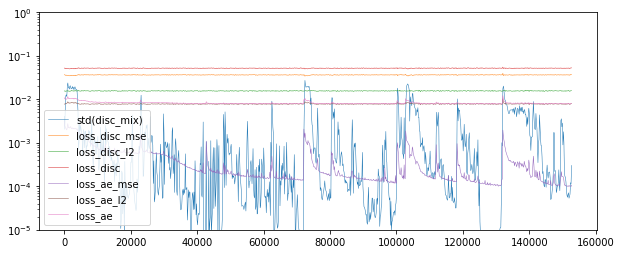

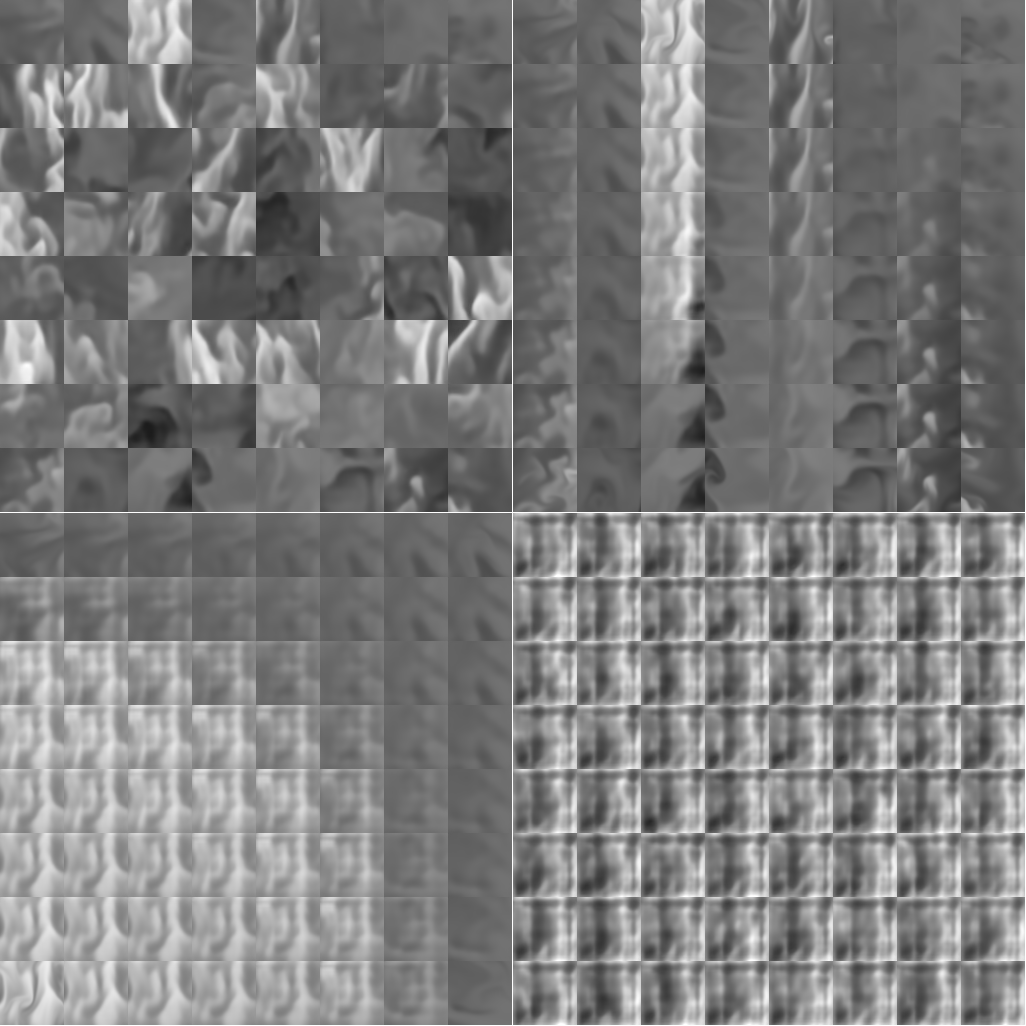

1/1; 266.82 samples/sec


In [48]:
import pdb
DEBUG_MODE = False

it = 0
start_time = time.time()
args['epochs'] = 1
checkpoint_name = "ACAI_small_noadv"

try:
    for epoch in range(args['epochs']):
        if DEBUG_MODE: pdb.set_trace()
        for x in turb_batches:
            z = encoder(x)
            out = decoder(z)
            disc = discriminator(torch.lerp(out, x, args['reg']))
        
            alpha = torch.rand(args['batch_size'], 1, 1, 1).to(args['device']) / 2
            z_mix = lerp(z, swap_halves(z), alpha)
            out_mix = decoder(z_mix)
            disc_mix = discriminator(out_mix)

            loss_ae_mse = F.mse_loss(out, x)
            loss_ae_l2 = L2(disc_mix) * args['advweight']
            loss_ae = loss_ae_mse + loss_ae_l2
            
            opt_ae.zero_grad()
            loss_ae.backward(retain_graph=True)
            opt_ae.step()
            
            loss_disc_mse = F.mse_loss(disc_mix, alpha.reshape(-1))
            loss_disc_l2 = L2(disc)
            loss_disc = loss_disc_mse + loss_disc_l2
            
            opt_d.zero_grad()
            loss_disc.backward()
            opt_d.step()

            losses['std(disc_mix)'].append(torch.std(disc_mix).item())
            losses['loss_disc_mse'].append(loss_disc_mse.item())
            losses['loss_disc_l2'].append(loss_disc_l2.item())
            losses['loss_disc'].append(loss_disc.item())
            losses['loss_ae_mse'].append(loss_ae_mse.item())
            losses['loss_ae_l2'].append(loss_ae_l2.item())
            losses['loss_ae'].append(loss_ae.item())

            if it % 100 == 0:
                img = status()
                
                plt.figure(facecolor='w', figsize=(10,4))
                for key in losses:
                    total = len(losses[key])
                    skip = 1 + (total // 1000)
                    y = build_batches(losses[key], skip).mean(axis=-1)
                    x = np.linspace(0, total, len(y))
                    plt.semilogy(x, y, label=key, lw=0.5)
                    plt.ylim((10e-6, 10e-1))
                plt.legend(loc='upper right')
                
                clear_output(wait=True)
                plt.show()
                show_array(img * 255)
                
                speed = args['batch_size'] * it / (time.time() - start_time)
                print(f'{epoch+1}/{args["epochs"]}; {speed:.2f} samples/sec')

            it += 1
        torch.save({
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_ae_state_dict': opt_ae.state_dict(),
            'opt_d_state_dict': opt_d.state_dict(),
            'losses': losses
            }, checkpoint_name + ".tar")
except KeyboardInterrupt:
    pass

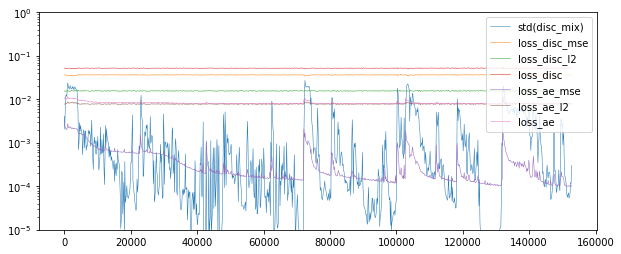

In [51]:
plt.figure(facecolor='w', figsize=(10,4))
for key in losses:
    total = len(losses[key])
    skip = 1 + (total // 1000)
    y = build_batches(losses[key], skip).mean(axis=-1)
    x = np.linspace(0, total, len(y))
    plt.semilogy(x, y, label=key, lw=0.5)
    plt.ylim((10e-6, 10e-1))
plt.legend(loc='upper right')

clear_output(wait=True)
plt.show()

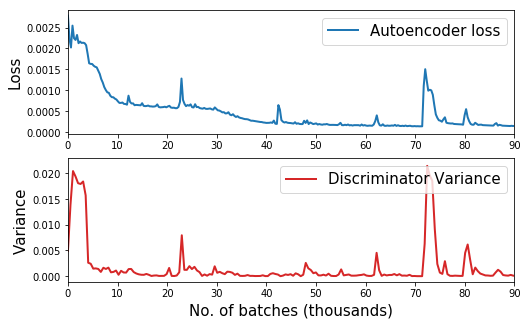

In [143]:
fontsize=15

plt.figure(facecolor='w', figsize=(8,5))
plt.subplot(2,1,1)
color='tab:blue'
key = 'loss_ae_mse'
total = len(losses[key])
skip = 1 + (total // 500)
y = build_batches(losses[key], skip).mean(axis=-1)
x = np.linspace(0, total//1000, len(y))
plt.plot(x, y, label='Autoencoder loss', lw=2,color=color)
plt.ylabel('Loss', fontsize=fontsize)
plt.xlim((0, 90))
plt.legend(loc='upper right', fontsize=fontsize)

plt.subplot(2, 1, 2)
color='tab:red'
key = 'std(disc_mix)'
skip = 1 + (total // 300)
y = build_batches(losses[key], skip).mean(axis=-1)
x = np.linspace(0, total//1000, len(y))
plt.plot(x, y, label='Discriminator Variance', lw=2, color=color)
plt.xlabel('No. of batches (thousands)', fontsize=fontsize)
plt.ylabel('Variance', fontsize=fontsize)
plt.xlim((0,90))

plt.legend(loc='upper right', fontsize=fontsize)
plt.show()

In [38]:
checkpoint_name = "ACAI_small_noadv"
torch.save({
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_ae_state_dict': opt_ae.state_dict(),
            'opt_d_state_dict': opt_d.state_dict(),
            'losses': losses
            }, checkpoint_name + ".tar")

In [28]:
import pdb

def mean_var( X ):
    X = X.to('cpu')
    X_mean = np.zeros(X.shape[3:4])
    X_var = np.zeros(X.shape[3:4])
    n_batches = X.shape[0]
    n_per_batch = X.shape[1]
    #psd = X.rfft(2, normalized=False, onesided=False).norm(dim=-1)**2
    #psdc = np.abs(np.fft.fft2(Xc))**2
    #X_meanc = psdc.mean(axis=(0,1,2))
    #X_varc = psdc.var(axis=(0,1,2))
    #psdc2 = psd.to('cpu').data.numpy()
    #X_mean = psd.mean((0,1,2))
    #X_var = psd.view(n_batches*n_per_batch, 64, 64).var(0)
    it = 0
    for k in range(n_batches):
        for j in range(n_per_batch):
            Y = np.abs(np.fft.fft2(X[k,j,0,:,:]))**2
            X_mean = (X_mean*it + Y)/(it+1)
            it += 1
            
    it = 0
    for k in range(n_batches):
        for j in range(n_per_batch):
            Y = np.abs(np.fft.fft2(X[k,j,0,:,:]))**2
            X_var = (X_var*it + (Y - X_mean)**2)/(it+1)
            it += 1
            
    return X_mean , X_var

# Computes the mean and variance spectrum of the data
turb_batches_fft_mean , turb_batches_fft_var = mean_var( turb_batches )

In [49]:
# Computes spectrum mean and variance of pixel-wise interpolated sample
X_lerp = 0.5*turb_batches[:50, :, :, :, :] + 0.5*turb_batches[50:100, :, :, :, :]
lerp_batch_fft_mean , lerp_batch_fft_var = mean_var( X_lerp )

# Computes spectrum mean and variance of an AE interpolated sample
n_samp = 50
X_ae_interp = np.zeros((n_samp, 64, 1, 64, 64))
for i in range(n_samp):
    X_ae_interp[i, :, :, :, :] = decoder(encoder(turb_batches[i, :, :, :, :]) 
                            + 0.5*encoder(turb_batches[n_samp+i, :, :, :, :])).detach().to('cpu')
ae_interp_batch_fft_mean , ae_interp_batch_fft_var = mean_var( torch.Tensor(X_ae_interp) )

# trade-off parameter between mean and variance difference
lambd = 1

# Computes difference
metric_lerp = np.linalg.norm(lerp_batch_fft_mean - turb_batches_fft_mean) +\
       lambd*np.linalg.norm(lerp_batch_fft_var - turb_batches_fft_var)
metric_ae = np.linalg.norm(ae_interp_batch_fft_mean - turb_batches_fft_mean) +\
       lambd*np.linalg.norm(ae_interp_batch_fft_var - turb_batches_fft_var)
print('Pixelwise Interpolation Score: {:E}'.format(metric_lerp))
print('AE Interpolation Score       : {:E}'.format(metric_ae))

Pixelwise Interpolation Score: 1.071118E+12
AE Interpolation Score       : 2.024099E+12


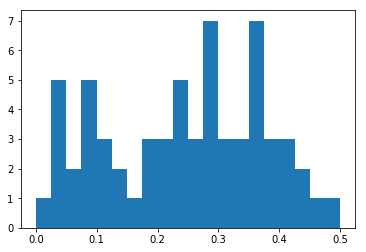

tensor([ 0.4716,  0.1186,  0.1578,  0.1075,  0.0665,  0.0794,  0.0294,  0.1893,
         0.3807,  0.2447,  0.3522,  0.0844,  0.0984,  0.2798,  0.3585,  0.0201,
         0.3639,  0.2558,  0.2200,  0.0618,  0.2756,  0.2908,  0.4322,  0.3950,
         0.0417,  0.2693,  0.4352,  0.3223, -0.0467,  0.1260,  0.3441,  0.3207,
         0.2104,  0.4863,  0.0354,  0.1981,  0.4000,  0.3505,  0.2811,  0.2550,
         0.1415,  0.2841,  0.0420,  0.4234,  0.0785,  0.1872,  0.3556,  0.2426,
         0.4056,  0.4159,  0.0295,  0.3728,  0.2254,  0.2292,  0.2849,  0.2406,
         0.2060,  0.3192,  0.2953,  0.3359,  0.1141,  0.3707,  0.0930,  0.3461],
       device='cuda:0', grad_fn=<MeanBackward0>)


In [41]:
# show the distribution of predictions from the discriminator
plt.hist(disc_mix.data.cpu().numpy(), range=[0,0.5], bins=20)
plt.show()
print(disc_mix)

In [ ]:
# distribution of each z dimension
z = encoder(turb_batches[0])
z = z.data.cpu().numpy().reshape(len(z), -1).T
for dim in z:
    plt.hist(dim, bins=12, alpha=0.1)
plt.show()